In [2]:
import getpass
import pandas as pd
import numpy as np
import urllib.parse
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Markdown as md

from shapely import wkb
from scipy.spatial import distance_matrix
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, value
import cvxpy as cp
from shapely import wkt
from shapely.geometry import LineString, Point

pd.set_option('display.max_columns', None)

In [3]:
def query_to_df(result):
    """
    Transform sql query result to dataframe, and
    expand out `meta` column into separate columns.
    """
    
    # Turn a query output into a Python dataframe.
    df = result.DataFrame()

    # Separate the `meta` column currently saved as JSONB into individual columns.
    # Replace NaN values to empty string for ease of spotting non-NaN values.
    df = pd.concat([df.drop(['meta'], axis=1),
                    df['meta'].apply(pd.Series).fillna('')], axis=1)
    
    # Transform the hex string form of geometry to coordinates.
    df['geometry'] = df['geometry'].apply(lambda x: wkb.loads(x, hex=True)) 
    
    return df

In [4]:
edm_address = getpass.getpass(prompt='EDM server address: ')  

print('\nEDM login information')
edm_name = getpass.getpass(prompt='Username: ') 
edm_password = getpass.getpass(prompt='Password: ') 
edm_password = urllib.parse.quote(edm_password)

%load_ext sql
%sql postgresql://$edm_name:$edm_password@$edm_address/edm
%config SqlMagic.displaycon = False
%config SqlMagic.feedback = False

# Delete the credential variables for security purpose.
del edm_name, edm_password

EDM server address:  ········



EDM login information


Username:  ········
Password:  ········


In [5]:
# User input for the grid.
grid_id = input('Enter grid ID: ') # awefice

Enter grid ID:  awefice


# Single point distance

In [6]:
%%sql

SELECT DISTINCT type as element_type
FROM grid_element
WHERE grid_id = '{grid_id}'
ORDER BY element_type;

element_type
ACLineSegment
Battery
Busbar
Cabinet
CircuitBreaker
Disconnector
EVCharger
Fuse
Jumper
Meter


In [7]:
element_type = input('Enter the element type of interest: ') # Transformer

# ACLineSegment

Enter the element type of interest:  Transformer


In [8]:
%%sql

SELECT grid_element_id
FROM grid_element
WHERE grid_id = '{grid_id}'
    AND type = '{element_type}'
ORDER BY grid_element_id;

grid_element_id
transformer_16
transformer_2
transformer_26
transformer_31
transformer_36
transformer_43
transformer_47
transformer_6
transformer_63
transformer_92


In [9]:
grid_element_id = input('Enter the grid element id of interest: ') # transformer_2

Enter the grid element id of interest:  transformer_2


In [10]:
trace_option = input('Enter the tracing option: ')  # all sources

Enter the tracing option:  all sources


In [16]:
if trace_option.lower() == 'source':
    
    # Set the third argument to `true` to retrieve the top feeder.
    result = %sql SELECT * \
            FROM grid_get_sources('{grid_id}', '{grid_element_id}', 'true');   
    
elif trace_option.lower() == 'all sources':
    
    # Set the third argument to `false` to retrieve all feeders.
    result = %sql SELECT * \
            FROM grid_get_sources('{grid_id}', '{grid_element_id}', 'false');
    
elif trace_option.lower() == 'down':
    
    # Set the third argument to `false` to exclude itself from the output.
    result = %sql SELECT * \
            FROM grid_get_downstream('{grid_id}', '{grid_element_id}', 'false');
    
elif trace_option.lower() == 'connected':
    
    result = %sql SELECT * \
            FROM grid_get_connected('{grid_id}', '{grid_element_id}');
    
elif trace_option.lower() == 'same voltage':
    
    result = %sql SELECT * \
            FROM grid_get_same_voltage('{grid_id}', '{grid_element_id}');

else:
    print('Invalid input for tracing option. Please enter one of the following: Source, All Sources, Down, Connected.')

In [17]:
result = %sql SELECT * \
            FROM grid_get_sources('{grid_id}', '{grid_element_id}', 'false')

In [19]:
# Turn the sql output to a Python dataframe.
df = query_to_df(result)

df_filtrado = df[
    (df['type'] == 'ACLineSegment') &
    (df['phases'] == 'ABC')
][['grid_element_id', 'geometry']]

df_filtrado

,grid_element_id,geometry
10,line_segment_143,LINESTRING (-123.104867049509 49.2669499965533...
12,line_segment_10,"LINESTRING (-123.10668133248 49.2675566618634,..."
13,line_segment_134,LINESTRING (-123.106687800683 49.2673858056582...
15,line_segment_21,LINESTRING (-123.103674247935 49.2673372461303...
16,line_segment_56,LINESTRING (-123.102840303093 49.2667344830283...
18,line_segment_12,LINESTRING (-123.106653447079 49.2673852487066...
19,line_segment_1,"LINESTRING (-123.104825836467 49.267355604155,..."
25,line_segment_20,"LINESTRING (-123.105657192908 49.267369092667,..."
27,line_segment_3,LINESTRING (-123.107134801681 49.2675640126912...
30,line_segment_11,LINESTRING (-123.106687800683 49.2673858056582...


In [20]:
result = %sql SELECT grid_element_id, \
                        meta, \
                        is_producer, \
                        geometry, \
                        phases\
                FROM grid_element\
                WHERE grid_id = '{grid_id}'\
                    AND type = 'Transformer';

# Convert the results to a data frame.
df_transformers = result.DataFrame()

# Pull out the information from `meta` column saved as JSONB.
df_transformers = pd.concat([df_transformers.drop(['meta'], axis=1),
                             df_transformers['meta'].apply(pd.Series)], axis=1)

# Choose the relevant columns to display transformers. 
df_transformers = df_transformers[['grid_element_id', 'ownership', 'rating_kva', 
                                   'phases', 'voltage_level', 'commission_date', 
                                   'primary_voltage', 'secondary_voltage','is_producer','geometry']]

# Display the results.
df_transformers

Transformers_info = df_transformers[['grid_element_id','is_producer','rating_kva', 'geometry']].set_index('grid_element_id')
Transformers_info['rating_kva'] = Transformers_info['rating_kva']
Transformers_info
Transformers_info

,is_producer,rating_kva,geometry
grid_element_id,,,
transformer_16,False,5.0,0101000020E6100000FBE59315C3C65EC00CF5264C39A2...
transformer_2,True,20000.0,0101000020E61000002B8A5759DBC65EC07AA4038A3FA2...
transformer_26,False,10.0,0101000020E610000083DC4598A2C65EC0EF130F4138A2...
transformer_31,False,30.0,0101000020E61000002B508BC1C3C65EC09C3C3CB62BA2...
transformer_36,False,50.0,0101000020E61000004D81CCCEA2C65EC0BA9955C82AA2...
transformer_43,False,75.0,0101000020E61000002463B5F97FC65EC0843DD45337A2...
transformer_47,False,150.0,0101000020E61000001F2E39EE94C65EC0A6A45E2224A2...
transformer_6,True,20000.0,0101000020E61000005A0EF450DBC65EC07EB981C843A2...
transformer_63,False,300.0,0101000020E61000009885764EB3C65EC04A8D3B6B58A2...


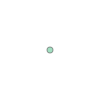

In [22]:
punto = wkb.loads(bytes.fromhex(Transformers_info['geometry'].iloc[0]))
punto

In [23]:
Distancias=pd.DataFrame()

In [24]:
Distancias['distancia'] = df_filtrado['geometry'].apply(lambda line: punto.distance(line))

In [25]:
Distancias

,distancia
10,0.000896
12,0.001031
13,0.001003
15,0.001983
16,0.002857
18,0.000004
19,0.000831
25,0.000004
27,0.001367
30,0.001031


In [27]:
Distancias['distancia'].min()

np.float64(4.4898719453835265e-06)

# For loop

In [28]:
result = %sql SELECT grid_element_id, \
                        meta, \
                        is_producer, \
                        geometry, \
                        phases\
                FROM grid_element\
                WHERE grid_id = '{grid_id}'\
                    AND type = 'Transformer';

# Convert the results to a data frame.
df_transformers = result.DataFrame()

# Pull out the information from `meta` column saved as JSONB.
df_transformers = pd.concat([df_transformers.drop(['meta'], axis=1),
                             df_transformers['meta'].apply(pd.Series)], axis=1)

# Choose the relevant columns to display transformers. 
df_transformers = df_transformers[['grid_element_id', 'ownership', 'rating_kva', 
                                   'phases', 'voltage_level', 'commission_date', 
                                   'primary_voltage', 'secondary_voltage','is_producer','geometry']]

# Display the results.
df_transformers

Transformers_info = df_transformers[['grid_element_id','is_producer','rating_kva', 'geometry']].set_index('grid_element_id')
Transformers_info['rating_kva'] = Transformers_info['rating_kva']
Transformers_info
Transformers_info

,is_producer,rating_kva,geometry
grid_element_id,,,
transformer_16,False,5.0,0101000020E6100000FBE59315C3C65EC00CF5264C39A2...
transformer_2,True,20000.0,0101000020E61000002B8A5759DBC65EC07AA4038A3FA2...
transformer_26,False,10.0,0101000020E610000083DC4598A2C65EC0EF130F4138A2...
transformer_31,False,30.0,0101000020E61000002B508BC1C3C65EC09C3C3CB62BA2...
transformer_36,False,50.0,0101000020E61000004D81CCCEA2C65EC0BA9955C82AA2...
transformer_43,False,75.0,0101000020E61000002463B5F97FC65EC0843DD45337A2...
transformer_47,False,150.0,0101000020E61000001F2E39EE94C65EC0A6A45E2224A2...
transformer_6,True,20000.0,0101000020E61000005A0EF450DBC65EC07EB981C843A2...
transformer_63,False,300.0,0101000020E61000009885764EB3C65EC04A8D3B6B58A2...


In [31]:
Transformers_info_Producer = Transformers_info[Transformers_info['is_producer']==False]
Transformers_info_Producer

,is_producer,rating_kva,geometry
grid_element_id,,,
transformer_16,False,5.0,0101000020E6100000FBE59315C3C65EC00CF5264C39A2...
transformer_26,False,10.0,0101000020E610000083DC4598A2C65EC0EF130F4138A2...
transformer_31,False,30.0,0101000020E61000002B508BC1C3C65EC09C3C3CB62BA2...
transformer_36,False,50.0,0101000020E61000004D81CCCEA2C65EC0BA9955C82AA2...
transformer_43,False,75.0,0101000020E61000002463B5F97FC65EC0843DD45337A2...
transformer_47,False,150.0,0101000020E61000001F2E39EE94C65EC0A6A45E2224A2...
transformer_63,False,300.0,0101000020E61000009885764EB3C65EC04A8D3B6B58A2...
transformer_92,False,750.0,0101000020E61000005B94D92093C65EC0F1C5CD5F57A2...


In [32]:
Transformers_info_Producer.loc['transformer_16', 'geometry']

'0101000020E6100000FBE59315C3C65EC00CF5264C39A24840'

In [33]:
Ts_Producer = Transformers_info[Transformers_info['is_producer'] == True].index.tolist()
Ts_Producer

['transformer_2', 'transformer_6']

In [34]:
Ts_Consumer = Transformers_info[Transformers_info['is_producer'] == False].index.tolist()
Ts_Consumer

['transformer_16',
 'transformer_26',
 'transformer_31',
 'transformer_36',
 'transformer_43',
 'transformer_47',
 'transformer_63',
 'transformer_92']

In [35]:
DF_Distancias = pd.DataFrame(0, index=Ts_Consumer, columns=Ts_Producer)
DF_Distancias

,transformer_2,transformer_6
transformer_16,0,0
transformer_26,0,0
transformer_31,0,0
transformer_36,0,0
transformer_43,0,0
transformer_47,0,0
transformer_63,0,0
transformer_92,0,0


In [36]:
DF_Distancias.at['transformer_16', 'transformer_2']

np.int64(0)

In [37]:
for producer in Ts_Producer:
    grid_element_id = producer
    trace_option = 'all sources'
    result = %sql SELECT * \
            FROM grid_get_sources('{grid_id}', '{grid_element_id}', 'false')

    #Lines
    df = query_to_df(result)
    
    df_filtrado = df[
        (df['type'] == 'ACLineSegment') &
        (df['phases'] == 'ABC')
    ][['grid_element_id', 'geometry']]
    
    for consumer in Ts_Consumer:
        punto = wkb.loads(bytes.fromhex(Transformers_info_Producer.loc[consumer, 'geometry']))
        Distancias=pd.DataFrame()
        Distancias['distancia'] = df_filtrado['geometry'].apply(lambda line: punto.distance(line))
        minima=Distancias['distancia'].min()
        DF_Distancias.at[consumer, producer] = minima
DF_Distancias

C:\Users\puerc\AppData\Local\Temp\ipykernel_74468\3433311283.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.4898719453835265e-06' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  DF_Distancias.at[consumer, producer] = minima
C:\Users\puerc\AppData\Local\Temp\ipykernel_74468\3433311283.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0005968969435544035' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  DF_Distancias.at[consumer, producer] = minima


,transformer_2,transformer_6
transformer_16,0.000004,0.000597
transformer_26,0.000004,0.000586
transformer_31,0.000004,0.000985
transformer_36,0.000002,0.000965
transformer_43,0.000003,0.000942
transformer_47,0.000002,0.001101
transformer_63,0.000970,0.000006
transformer_92,0.000967,0.000006


In [38]:
Distances_array = DF_Distancias.values
Distances_array

array([[4.48987195e-06, 5.96896944e-04],
       [4.49683585e-06, 5.86193575e-04],
       [4.49770634e-06, 9.84772428e-04],
       [2.15920988e-06, 9.64518848e-04],
       [3.20526379e-06, 9.42174919e-04],
       [2.31335839e-06, 1.10143569e-03],
       [9.69704305e-04, 5.62513663e-06],
       [9.66662579e-04, 5.68465438e-06]])